In [1]:
# Import necessary libraries
import numpy as np                  
import pandas as pd                 
import matplotlib.pyplot as plt     
from sklearn.preprocessing import OneHotEncoder 

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

In [2]:
def preprocess_dataset(betting_data_dfs):
    # Replace 'NR' (Not Ranked) with NaN in 'WRank' and 'LRank' columns
    betting_data_dfs['WRank'].replace('NR', np.nan, inplace=True)
    betting_data_dfs['LRank'].replace('NR', np.nan, inplace=True)
    
    # Convert 'WRank' and 'LRank' columns to numeric, forcing errors to NaN
    betting_data_dfs['WRank'] = pd.to_numeric(betting_data_dfs['WRank'], errors='coerce')
    betting_data_dfs['LRank'] = pd.to_numeric(betting_data_dfs['LRank'], errors='coerce')

    # Fill NaN values in 'WRank' and 'LRank' with 100000 and convert to float
    betting_data_dfs['WRank'] = betting_data_dfs['WRank'].fillna(100000).astype(float)
    betting_data_dfs['LRank'] = betting_data_dfs['LRank'].fillna(100000).astype(float)

    # Create a column indicating if the higher-ranked player won (1 if true, 0 if false)
    betting_data_dfs['higher_rank_won'] = (betting_data_dfs['WRank'] < betting_data_dfs['LRank']).astype(int)

    # Define the essential columns to keep in the dataframe
    essential_columns = [ 'Date', 'WRank', 'LRank', 'higher_rank_won', 'Winner', 'Loser']

    # Filter the dataframe to keep only the essential columns
    betting_data_filtered = betting_data_dfs[essential_columns]

    # Return the preprocessed dataframe
    return betting_data_filtered

In [3]:
def update_elo(winner_elo, loser_elo, K):
    # Calculate expected score for the winner
    expected_winner = 1 / (1 + 10 ** ((loser_elo - winner_elo) / 400))
    
    # Calculate the change in Elo ratings for the winner
    elo_change_winner = K * (1 - expected_winner)
    
    # Calculate the change in Elo ratings for the loser
    elo_change_loser = K * (expected_winner - 1)

    # Update the Elo ratings by adding the change to the original ratings
    updated_winner_elo = winner_elo + elo_change_winner
    updated_loser_elo = loser_elo + elo_change_loser

    # Return the updated Elo ratings and the expected score for the winner
    return (updated_winner_elo, updated_loser_elo, expected_winner)

In [4]:
def calculate_elo_with_k(betting_data_dfs_preprocessed, k):
    players_ids = pd.concat([betting_data_dfs_preprocessed['Winner'], betting_data_dfs_preprocessed['Loser']]).unique()
    elo_scores_constant_k = {player: 1500 for player in players_ids}

    for i in range(len(betting_data_dfs_preprocessed)):
        tennis_match_row = betting_data_dfs_preprocessed.iloc[i]
        winner_id = tennis_match_row['Winner']
        loser_id = tennis_match_row['Loser']
        higher_ranked_wins = tennis_match_row['higher_rank_won']


        winner_elo_before, loser_elo_before = elo_scores_constant_k[winner_id], elo_scores_constant_k[loser_id]


        winner_elo_after, loser_elo_after, prob_winner = update_elo(
            winner_elo_before, loser_elo_before, k)

        elo_scores_constant_k[winner_id], elo_scores_constant_k[loser_id] = winner_elo_after, loser_elo_after


        betting_data_dfs_preprocessed.at[i, 'winner_elo_before'] = winner_elo_before
        betting_data_dfs_preprocessed.at[i, 'winner_elo_after'] = winner_elo_after
        betting_data_dfs_preprocessed.at[i, 'loser_elo_before'] = loser_elo_before
        betting_data_dfs_preprocessed.at[i, 'loser_elo_after'] = loser_elo_after

        prob_winner = 1 / (1 + 10 ** ((loser_elo_before - winner_elo_before) / 400))
        betting_data_dfs_preprocessed.at[i, 'prob_winner'] = prob_winner

        if tennis_match_row['higher_rank_won'] == 1:
            betting_data_dfs_preprocessed.at[i, 'match_outcome'] = int(betting_data_dfs_preprocessed.at[i, 'prob_winner'] > 0.5)  # Convert boolean to int using int()
            betting_data_dfs_preprocessed.at[i, 'prob_high_ranked'] = betting_data_dfs_preprocessed.at[i, 'prob_winner']
        else:
            betting_data_dfs_preprocessed.at[i, 'match_outcome'] = int((1 - betting_data_dfs_preprocessed.at[i, 'prob_winner']) > 0.5)  # Convert boolean to int using int()
            betting_data_dfs_preprocessed.at[i, 'prob_high_ranked'] = 1 - betting_data_dfs_preprocessed.at[i, 'prob_winner']
            

In [5]:
def accuracy(actual, predictions):
    # Calculate the mean of correct predictions
    logr_accuracy_all_predictors = np.round(np.mean(actual == predictions),4)
    return logr_accuracy_all_predictors

def calibration(actual, predictions):
    # Calculate the ratio of the sum of predictions to the sum of actual values
    return np.round((np.sum(predictions) / np.sum(actual)), 4)

def logloss(actual, predictions):
    epsilon = 1e-15  # Small constant to prevent division by zero
    # Clip predictions to avoid log of zero. Values are clipped to the range [epsilon, 1-epsilon]
    predictions = np.clip(predictions, epsilon, 1 - epsilon)
    
    
    logr_logloss_all_predictors = -(1 / len(actual)) * np.sum(
        actual * np.log(predictions) + (1 - actual) * np.log(1 - predictions))
    return np.round(logr_logloss_all_predictors, 4)

In [6]:
# Evaluating predictions using accuracy, calibration and logloss
def evaluate_predictions(actual_outcomes, binary_predictions, probability_predictions):
    accuracy_result = accuracy(actual_outcomes, binary_predictions)
    
    calibration_result = calibration(actual_outcomes, probability_predictions)
    
    logloss_result = logloss(actual_outcomes, probability_predictions)
    
    return {
        accuracy_result,  
        calibration_result,  
        logloss_result  
    }

In [7]:
# Initialize a dictionary to store dataframes for each year
betting_data_dfs = {}

In [8]:
# Loop through each year from 2005 to 2019
for current_year in range(2005, 2020): 
    # Determine the file extension based on the year
    file_extension = 'xls' if current_year < 2013 else 'xlsx'
    
    # Construct the file path using the determined file extension
    file_path = f"Betting_Odds_Tennis/{current_year}.{file_extension}"
    
    # Read the Excel file and store it in the dictionary with the year as the key
    betting_data_dfs[current_year] = pd.read_excel(file_path)

In [9]:
betting_data_dfs[2019]

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,Lsets,Comment,B365W,B365L,PSW,PSL,MaxW,MaxL,AvgW,AvgL
0,1,Brisbane,Brisbane International,2018-12-31,ATP250,Outdoor,Hard,1st Round,3,Dimitrov G.,...,0.0,Completed,1.36,3.00,1.36,3.37,1.42,3.60,1.35,3.18
1,1,Brisbane,Brisbane International,2018-12-31,ATP250,Outdoor,Hard,1st Round,3,Raonic M.,...,0.0,Completed,1.18,4.50,1.23,4.68,1.27,4.84,1.22,4.26
2,1,Brisbane,Brisbane International,2018-12-31,ATP250,Outdoor,Hard,1st Round,3,Kecmanovic M.,...,0.0,Completed,1.57,2.25,1.67,2.32,1.71,2.40,1.63,2.28
3,1,Brisbane,Brisbane International,2018-12-31,ATP250,Outdoor,Hard,1st Round,3,Millman J.,...,1.0,Completed,1.40,2.75,1.41,3.13,1.45,3.20,1.40,2.95
4,1,Brisbane,Brisbane International,2018-12-31,ATP250,Outdoor,Hard,1st Round,3,Uchiyama Y.,...,0.0,Completed,2.62,1.44,2.73,1.51,3.26,1.53,2.69,1.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2605,66,London,Masters Cup,2019-11-15,Masters Cup,Indoor,Hard,Round Robin,3,Nadal R.,...,1.0,Completed,1.44,2.75,1.39,3.26,1.48,3.30,1.41,2.93
2606,66,London,Masters Cup,2019-11-15,Masters Cup,Indoor,Hard,Round Robin,3,Zverev A.,...,0.0,Completed,1.90,1.90,2.14,1.79,2.24,2.06,1.92,1.90
2607,66,London,Masters Cup,2019-11-16,Masters Cup,Indoor,Hard,Semifinals,3,Tsitsipas S.,...,0.0,Completed,3.50,1.30,3.75,1.33,3.75,1.40,3.39,1.33
2608,66,London,Masters Cup,2019-11-16,Masters Cup,Indoor,Hard,Semifinals,3,Thiem D.,...,0.0,Completed,1.80,2.00,1.84,2.10,1.87,2.20,1.78,2.06


In [10]:
# Combine DataFrames from all years into a single DataFrame, reindexing rows.
betting_data_dfs = pd.concat(betting_data_dfs.values(), ignore_index = True)

In [11]:
# Display a summary of the DataFrame to understand its structure and data types
betting_data_dfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40390 entries, 0 to 40389
Data columns (total 48 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ATP         40390 non-null  int64         
 1   Location    40390 non-null  object        
 2   Tournament  40390 non-null  object        
 3   Date        40390 non-null  datetime64[ns]
 4   Series      40390 non-null  object        
 5   Court       40390 non-null  object        
 6   Surface     40390 non-null  object        
 7   Round       40390 non-null  object        
 8   Best of     40390 non-null  int64         
 9   Winner      40390 non-null  object        
 10  Loser       40390 non-null  object        
 11  WRank       40375 non-null  float64       
 12  LRank       40303 non-null  float64       
 13  WPts        38701 non-null  float64       
 14  LPts        38631 non-null  float64       
 15  W1          40155 non-null  float64       
 16  L1          40157 non-

In [12]:
# Generate descriptive statistics for numerical columns in the DataFrame
betting_data_dfs.describe()

,ATP,Best of,WRank,LRank,WPts,LPts,W1,L1,W4,L4,...,UBW,UBL,LBW,LBL,SJW,SJL,MaxW,MaxL,AvgW,AvgL
count,40390.000000,40390.000000,40375.000000,40303.000000,38701.000000,38631.000000,40155.000000,40157.000000,3647.000000,3647.000000,...,10671.000000,10671.000000,28131.000000,28142.000000,15572.000000,15579.000000,25354.000000,25354.000000,25354.000000,25354.000000
mean,32.974944,3.378311,57.801536,90.384860,1828.537195,1054.728379,5.801992,4.075155,5.783384,3.865643,...,1.815867,3.542479,1.810226,3.451461,1.796538,3.557943,1.998610,7.847864,1.838168,3.547658
std,18.006138,0.783274,72.735132,115.423997,2278.996487,1212.422674,1.232787,1.841617,1.262227,1.903181,...,0.996238,3.646316,1.031691,3.075889,1.004273,3.272510,1.582432,376.246830,1.089277,3.227770
min,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.010000,1.020000,1.000000,1.000000,1.000000,1.010000,1.010000,1.010000,1.010000,1.010000
25%,19.000000,3.000000,16.000000,34.000000,645.000000,502.000000,6.000000,3.000000,6.000000,2.000000,...,1.240000,1.750000,1.250000,1.730000,1.220000,1.730000,1.300000,1.840000,1.250000,1.740000
50%,33.000000,3.000000,40.000000,64.000000,1010.000000,745.000000,6.000000,4.000000,6.000000,4.000000,...,1.500000,2.500000,1.500000,2.500000,1.500000,2.630000,1.580000,2.750000,1.510000,2.530000
75%,49.000000,3.000000,75.000000,102.000000,1890.000000,1150.000000,6.000000,6.000000,6.000000,6.000000,...,2.030000,3.850000,2.000000,4.000000,2.000000,4.000000,2.210000,4.470000,2.070000,3.910000
max,67.000000,5.000000,1890.000000,2159.000000,16950.000000,16950.000000,7.000000,7.000000,7.000000,7.000000,...,18.000000,60.000000,26.000000,51.000000,19.000000,81.000000,76.000000,42586.000000,23.450000,36.440000


In [13]:
# Retrieve and display the column names of the DataFrame
betting_data_dfs.columns

Index(['ATP', 'Location', 'Tournament', 'Date', 'Series', 'Court', 'Surface',
       'Round', 'Best of', 'Winner', 'Loser', 'WRank', 'LRank', 'WPts', 'LPts',
       'W1', 'L1', 'W2', 'L2', 'W3', 'L3', 'W4', 'L4', 'W5', 'L5', 'Wsets',
       'Lsets', 'Comment', 'B365W', 'B365L', 'CBW', 'CBL', 'EXW', 'EXL', 'IWW',
       'IWL', 'PSW', 'PSL', 'UBW', 'UBL', 'LBW', 'LBL', 'SJW', 'SJL', 'MaxW',
       'MaxL', 'AvgW', 'AvgL'],
      dtype='object')

In [14]:
betting_data_dfs_preprocessed = preprocess_dataset(betting_data_dfs) 

In [15]:
betting_data_dfs_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40390 entries, 0 to 40389
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             40390 non-null  datetime64[ns]
 1   WRank            40390 non-null  float64       
 2   LRank            40390 non-null  float64       
 3   higher_rank_won  40390 non-null  int64         
 4   Winner           40390 non-null  object        
 5   Loser            40390 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 1.8+ MB


In [16]:
means = betting_data_dfs_preprocessed.select_dtypes(include=[np.number]).mean()
betting_data_dfs_preprocessed.fillna(means, inplace=True)

In [17]:
players_ids = pd.concat([betting_data_dfs_preprocessed['Winner'], betting_data_dfs_preprocessed['Loser']]).unique()
players_ids

array(['Saulnier C.', 'Enqvist T.', 'Melzer J.', ..., 'Dubrivnyy A.',
       'Kachmazov A.', 'Medvedev D. '], dtype=object)

In [18]:
# Initialize a list to store results for different K values
results = []

# Loop through K values from 1 to 100
for k in range(1, 100):
    # Create a copy of the preprocessed betting data for safe manipulation
    betting_data_copy = betting_data_dfs_preprocessed.copy()

    # Calculate Elo scores using the current K value
    calculate_elo_with_k(betting_data_copy, k)

    # Filter the data for validation based on the date
    betting_data_dfs_preprocessed_validation = betting_data_copy[betting_data_copy.Date > '2018-12-31']

    # Ensure 'match_outcome' is of integer type for consistency in calculations
    betting_data_dfs_preprocessed_validation["match_outcome"] = betting_data_dfs_preprocessed_validation["match_outcome"].astype(int)

    # Evaluate predictions and compute accuracy, calibration, and log loss
    accuracy1, calibration1, log_loss1 = evaluate_predictions(
        betting_data_dfs_preprocessed_validation["higher_rank_won"],
        betting_data_dfs_preprocessed_validation["match_outcome"], 
        betting_data_dfs_preprocessed_validation['prob_high_ranked']
    )

    # Store the results for this K value
    results.append((k, accuracy1, calibration1, log_loss1))

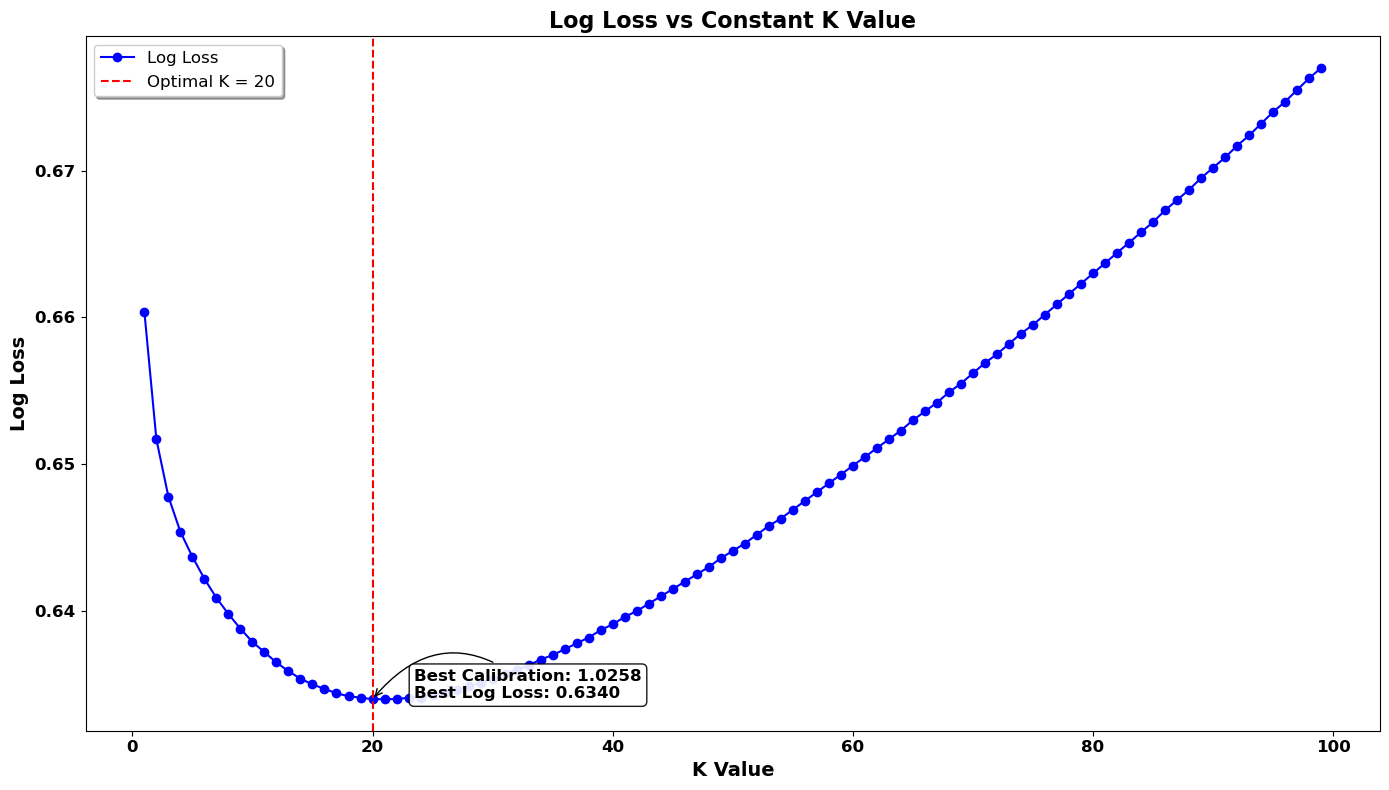

In [20]:
k_values = [result[0] for result in results]
accuracies = [float(result[1]) for result in results]  # Assuming accuracies are also being analyzed
calibrations = [float(result[2]) for result in results]
log_losses = [float(result[3]) for result in results]

# Finding the index of the minimum log loss
index_of_min_log_loss = log_losses.index(min(log_losses))

# Using the index to retrieve the optimal K and corresponding metrics
optimal_k_log_loss = k_values[index_of_min_log_loss]
best_calibration = calibrations[index_of_min_log_loss]
best_log_loss = log_losses[index_of_min_log_loss]

# Plotting the results for log loss across different K values
plt.figure(figsize=(14, 8))
plt.plot(k_values, log_losses, label='Log Loss', color='blue', marker='o')  # Added markers for clarity
plt.axvline(optimal_k_log_loss, color='red', linestyle='--', label=f'Optimal K = {optimal_k_log_loss}')

# Set labels and titles with enhanced font settings
plt.xlabel('K Value', fontsize=14, fontweight='bold')
plt.ylabel('Log Loss', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.legend(fontsize=12, frameon=True, shadow=True)
plt.title('Log Loss vs Constant K Value', fontsize=16, fontweight='bold')

# Annotating the graph with the best calibration and log loss values
# Bounding box and arrow style are adjusted for better visibility
annotation_text = f'Best Calibration: {best_calibration:.4f}\nBest Log Loss: {best_log_loss:.4f}'
plt.annotate(annotation_text,
             xy=(optimal_k_log_loss, best_log_loss),
             xytext=(optimal_k_log_loss + 10, best_log_loss - 0.05),  # Adjust text position for better legibility
             textcoords="offset points",  # This ensures that the positioning is relative
             bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white', alpha=0.9),
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.5", color='black'),
             fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()